In [18]:
from warnings import simplefilter

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.ticker import MaxNLocator

from sktime.datasets import load_airline
from sktime.forecasting.base import ForecastingHorizon
from sktime.split import (
    CutoffSplitter,
    ExpandingWindowSplitter,
    SingleWindowSplitter,
    SlidingWindowSplitter,
    temporal_train_test_split,
)
from sktime.utils.plotting import plot_series

In [22]:


def plot_windows(y, train_windows, test_windows, title=""):
    """Visualize training and test windows."""
    simplefilter("ignore", category=UserWarning)

    def get_y(length, split):
        # Create a constant vector based on the split for y-axis."""
        return np.ones(length) * split

    n_splits = len(train_windows)
    n_timepoints = len(y)
    len_test = len(test_windows[0])

    train_color, test_color = sns.color_palette("colorblind")[:2]

    fig, ax = plt.subplots(figsize=plt.figaspect(0.3))

    for i in range(n_splits):
        train = train_windows[i]
        test = test_windows[i]

        ax.plot(
            np.arange(n_timepoints), get_y(n_timepoints, i), marker="o", c="lightgray"
        )
        ax.plot(
            train,
            get_y(len(train), i),
            marker="o",
            c=train_color,
            label="Window",
        )
        ax.plot(
            test,
            get_y(len_test, i),
            marker="o",
            c=test_color,
            label="Forecasting horizon",
        )
    ax.invert_yaxis()
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    ax.set(
        title=title,
        ylabel="Window number",
        xlabel="Time",
        xticklabels=y.index,
    )
    # remove duplicate labels/handles
    handles, labels = ((leg[:2]) for leg in ax.get_legend_handles_labels())
    ax.legend(handles, labels)

Number of Folds = 29


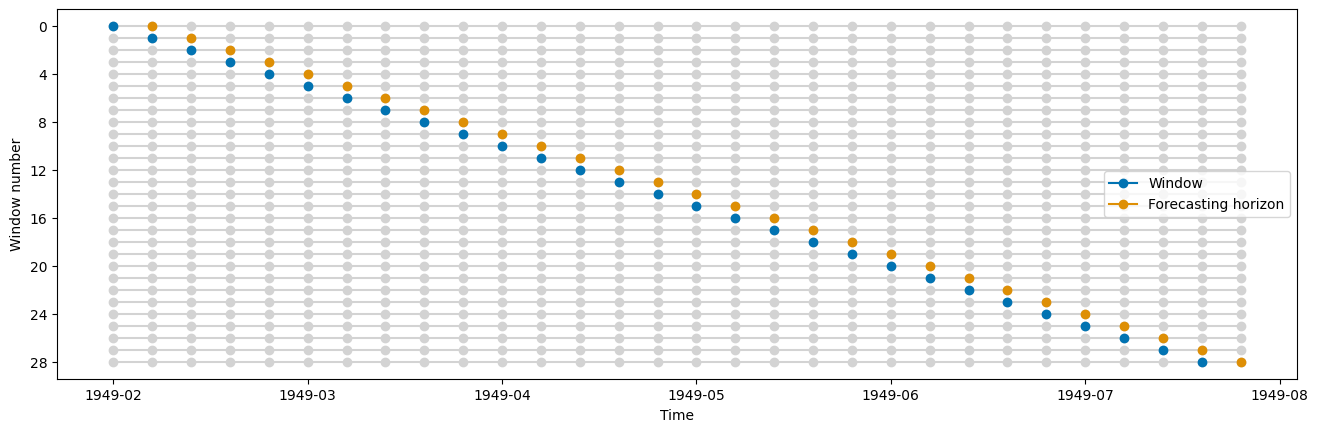

In [23]:

def get_windows(y, cv):
    """Generate windows."""
    train_windows = []
    test_windows = []
    for i, (train, test) in enumerate(cv.split(y)):
        train_windows.append(train)
        test_windows.append(test)
    return train_windows, test_windows

# set splitter parameters
window_length = 1
fh = ForecastingHorizon([1])
cv = SlidingWindowSplitter(window_length=window_length, fh=fh)

n_splits = cv.get_n_splits(y)
print(f"Number of Folds = {n_splits}")

train_windows, test_windows = get_windows(y, cv)
plot_windows(y, train_windows, test_windows)

Mean Forecast - MAPE (Last 10 Observations): 10.78%
Last Forecast - MAPE (Last 10 Observations): 9.22%


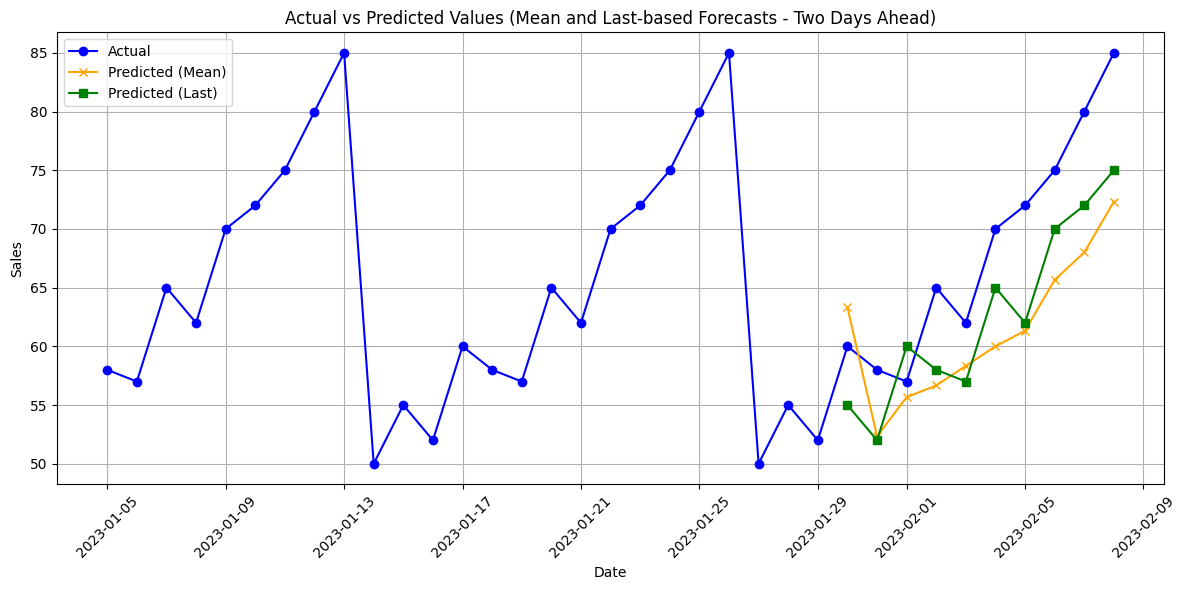

            Actual  Predicted Mean  Predicted Last
2023-01-05      58             NaN             NaN
2023-01-06      57             NaN             NaN
2023-01-07      65             NaN             NaN
2023-01-08      62             NaN             NaN
2023-01-09      70             NaN             NaN
2023-01-10      72             NaN             NaN
2023-01-11      75             NaN             NaN
2023-01-12      80             NaN             NaN
2023-01-13      85             NaN             NaN
2023-01-14      50             NaN             NaN
2023-01-15      55             NaN             NaN
2023-01-16      52             NaN             NaN
2023-01-17      60             NaN             NaN
2023-01-18      58             NaN             NaN
2023-01-19      57             NaN             NaN
2023-01-20      65             NaN             NaN
2023-01-21      62             NaN             NaN
2023-01-22      70             NaN             NaN
2023-01-23      72             

In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sktime.forecasting.naive import NaiveForecaster
from sktime.split import SlidingWindowSplitter

# Example time series data (daily sales data with dates)
date_rng = pd.date_range(start='2023-01-01', end='2023-02-08', freq='D')  # Corrected end date
sales_data = [50, 55, 52, 60, 58, 57, 65, 62, 70, 72, 75, 80, 85] * 3
y = pd.Series(sales_data, index=date_rng, name="sales")

# Set splitter parameters
window_length = 3  # Training window length
fh = [2]  # Forecast two days ahead (day after tomorrow)
cv = SlidingWindowSplitter(window_length=window_length, fh=fh)

# Get the number of splits and generate training/test windows
def get_windows(y, cv):
    train_windows = []  
    test_windows = []   
    for i, (train, test) in enumerate(cv.split(y)):
        train_windows.append(train)  
        test_windows.append(test)     
    return train_windows, test_windows  

train_windows, test_windows = get_windows(y, cv)

# Initialize lists to store predictions
predictions_mean = []
predictions_last = []

# Iterate over each split (window)
for i in range(len(train_windows)):
    train_idx = train_windows[i]
    test_idx = test_windows[i]
    
    y_train = y.iloc[train_idx]
    y_test = y.iloc[test_idx]

    # Forecasting with "mean" strategy
    forecaster_mean = NaiveForecaster(strategy="mean")
    forecaster_mean.fit(y_train)
    y_pred_mean = forecaster_mean.predict(fh=fh)
    predictions_mean.append(y_pred_mean)

    # Forecasting with "last" strategy
    forecaster_last = NaiveForecaster(strategy="last")
    forecaster_last.fit(y_train)
    y_pred_last = forecaster_last.predict(fh=fh)
    predictions_last.append(y_pred_last)

# Combine predictions into series
predictions_mean_series = pd.Series(np.concatenate(predictions_mean), index=y.index[window_length + 1:])
predictions_last_series = pd.Series(np.concatenate(predictions_last), index=y.index[window_length + 1:])

# Create a DataFrame for results
results_df = pd.DataFrame({
    'Actual': y.iloc[window_length + 1:],  
    'Predicted Mean': predictions_mean_series,
    'Predicted Last': predictions_last_series
})

# Keep all actual observations and only the last 10 for predictions
results_df['Predicted Mean'] = results_df['Predicted Mean'].where(results_df.index.isin(results_df.index[-10:]), np.nan)
results_df['Predicted Last'] = results_df['Predicted Last'].where(results_df.index.isin(results_df.index[-10:]), np.nan)

# Calculate MAPE for the last 10 observations
last_10_results_df = results_df.tail(10)

# Define MAPE function
def mean_absolute_percentage_error(y_true, y_pred):
    """Calculate Mean Absolute Percentage Error (MAPE)."""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    nonzero_mask = y_true != 0  # Avoid division by zero
    return np.mean(np.abs((y_true[nonzero_mask] - y_pred[nonzero_mask]) / y_true[nonzero_mask])) * 100

# Calculate MAPE for both prediction strategies based on the last 10 observations
mape_mean_last_10 = mean_absolute_percentage_error(last_10_results_df['Actual'], last_10_results_df['Predicted Mean'])
mape_last_last_10 = mean_absolute_percentage_error(last_10_results_df['Actual'], last_10_results_df['Predicted Last'])

print(f"Mean Forecast - MAPE (Last 10 Observations): {mape_mean_last_10:.2f}%")
print(f"Last Forecast - MAPE (Last 10 Observations): {mape_last_last_10:.2f}%")

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(results_df.index, results_df['Actual'], label='Actual', marker='o', color='blue')
plt.plot(results_df.index, results_df['Predicted Mean'], label='Predicted (Mean)', marker='x', color='orange')
plt.plot(results_df.index, results_df['Predicted Last'], label='Predicted (Last)', marker='s', color='green')

plt.title('Actual vs Predicted Values (Mean and Last-based Forecasts - Two Days Ahead)')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.grid()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Show the results (first 20 days for preview)
print(results_df.head(20))
